In [1]:
import numpy as np
import sys
sys.path+=['../']
from IntegrableResonanceModel import IntegrableResonanceModel
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

/Users/shadden/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Semi-numerical determination of actions and frequencies.

This notebook demonstrates code for performing the semi-numerical transformation to action-angle variables,
$$
{\cal J} = \frac{1}{2\pi}\oint Jd\theta~~;~~\zeta =\frac{2\pi}{T_\text{res}}t \\
{\cal J}^* =J^* ~~;~~\zeta^*=\theta^*+\rho({\zeta};{\cal J}^*,{\cal J})
$$
according to the method described in <a href=https://ui.adsabs.harvard.edu/abs/1990CeMDA..49...43H/abstract>Henrard (1990)</a>. 

The function `calc_action_and_frequencies` defined in `IntegrableModelUtils.py` computes ${\cal J}$ along with 
$$
\Omega_\text{res}=\frac{\partial H_0 }{ \partial{\cal J}}\\
\Omega_\text{sec}=\frac{\partial H_0 }{ \partial{\cal J}^*}
$$

Initialize a resonance model

In [2]:
#**** Note *******
# Computing accurate secular frequencies can
# require increasing the number of quadrature points
# above the default
res_model = IntegrableResonanceModel(3,1,n_quad_pts=61)

Import `calc_action_and_frequencies` to compute actions plus resonant and secular frequencies. We'll compute these on a grid of initial conditions below.

In [3]:
from IntegrableModelUtils import calc_action_and_frequencies

Define grid of intial conditions

In [4]:
Ngrid= 40
zfracs = np.linspace(0.1,0.8,Ngrid)
amps = np.linspace(0,np.pi-0.2,Ngrid) 
# Note, we'll stop shy of np.pi in 'amps'
# because it gets expensive to compute actions as the
# libration period diverges...

Compute actions and frequencies

In [5]:
action,Ores,Osec = np.zeros((3,Ngrid,Ngrid))
for i,zf in enumerate(zfracs):
    _,_,Z = res_model.get_z1z2Z_from_zfrac(zf)
    Jstar = res_model.Zsq_to_J * (Z)**2
    yell = res_model.elliptic_fixed_point(Jstar)
    yunst = res_model.unstable_fixed_point(Jstar)
    for j,librationAmplitude in enumerate(amps):
        y0 = yell + (yunst-yell) * librationAmplitude / np.pi
        action[i,j],Ores[i,j],Osec[i,j] = calc_action_and_frequencies(y0,res_model)

Make a contour plot

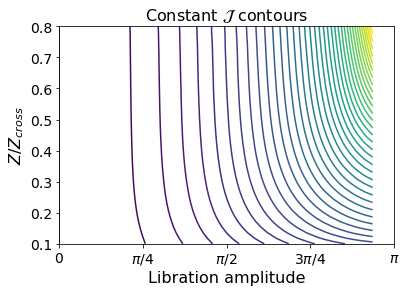

In [12]:
plt.contour(*np.meshgrid(amps,zfracs),-1 * action,np.linspace(0,-1*np.min(action),40)[:-1])
plt.xlim(0,np.pi)
plt.xlabel("Libration amplitude",fontsize=16)
plt.ylabel(r"$Z/Z_{cross}$",fontsize=16)
plt.xticks([0,np.pi/4,np.pi/2,3 * np.pi/4,np.pi],[r"$0$",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"],fontsize=14)
plt.yticks(fontsize=14)
plt.title("Constant ${\cal J}$ contours",fontsize=16)

Examine the frequencies' dependence on libration amplitude for a few select values of $J^*$

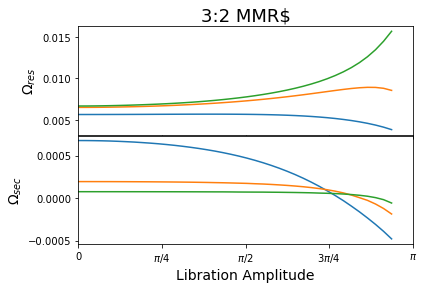

In [13]:
fig,ax = plt.subplots(2,sharex=True,figsize=(6,4))
plt.subplots_adjust(hspace=0.01)

# NOTE: Omega_sec needs to be corrected with
# addition of $\epsilon * b_s$ 
a_s,b_s,c_s = res_model.secular_coeffs()
eps_bs = b_s * res_model.eps
for i in [5,Ngrid//2,Ngrid-1]:
    zf = zfracs[i]
    ax[0].plot(amps,Ores[i],label=r"$Z/Z_{cross}=$"+"{:.2f}".format(zf))
    ax[1].plot(amps,Osec[i]+eps_bs)


ax[1].set_xticks([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi])
ax[1].xaxis.set_ticklabels(["0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"]);
ax[0].set_title("{}:{} MMR$".format(res_model.j,res_model.j-res_model.k),fontsize = 18)
ax[1].set_xlim(0,np.pi)
ax[1].set_xlabel("Libration Amplitude",fontsize=14)
ax[0].set_ylabel(r"$\Omega_{res}$",fontsize=14)
ax[1].set_ylabel(r"$\Omega_{sec}$",fontsize=14)